# Imports

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Local Code
from config import *
# from gan import GAN, cGAN
# from ae_gan import GAN, cGAN
from began import BEGAN, cBEGAN
from autoencoder import Autoencoder
from dataset import *

# Load Models and Geneate Data

In [2]:
# Path to the file
file_path = os.path.join(TRAINED_MODELS_DIR_PATH, 'gan', 'best_model.pth')

# Check if the file exists
if os.path.exists(file_path):
    print(f"File found: {file_path}")
else:
    print(f"File not found: {file_path}")

File found: Trained Models\gan\best_model.pth


In [3]:
# Initialize the models with pretrained weights
autoencoder = Autoencoder(
        encoder_config=ENCODER_CONFIG,
        decoder_config=DECODER_CONFIG,
        pretrained_path=os.path.join(TRAINED_MODELS_DIR_PATH, 'ae', 'best_model.pth')
    ).to(DEVICE)

# gan = GAN(
#     gen_config=GENERATOR_CONFIG, 
#     disc_config=DISCRIMINATOR_CONFIG,
#     autoencoder=autoencoder, 
#     pretrained_path=os.path.join(TRAINED_MODELS_DIR_PATH, 'gan', 'best_model.pth')
# )

# cgan = cGAN(
#     gen_config=GENERATOR_CONFIG, 
#     disc_config=DISCRIMINATOR_CONFIG,
#     autoencoder=autoencoder,
#     num_classes=NUM_CLASSES, 
#     pretrained_path=os.path.join(TRAINED_MODELS_DIR_PATH, 'cgan', 'best_model.pth')
# )

gan = BEGAN(gen_config=GENERATOR_CONFIG,
                    pretrained_autoencoder=autoencoder,
                    pretrained_path=os.path.join(TRAINED_MODELS_DIR_PATH, 'gan', 'best_model.pth'),
                    gamma=GAMMA,
                    lambda_k=LAMBDA_K)

cgan = cBEGAN(gen_config=GENERATOR_CONFIG,
            pretrained_autoencoder=autoencoder,
            gamma=GAMMA,
            lambda_k=LAMBDA_K,
            num_classes=NUM_CLASSES,
            pretrained_path=os.path.join(TRAINED_MODELS_DIR_PATH, 'cgan', 'best_model.pth'))

# Ensure the model is in evaluation mode
gan.eval(), cgan.eval()

[Model Status]: Building <class 'autoencoder.Autoencoder'> Model...
[Model Status]: Loading weights from Trained Models\ae\best_model.pth
[Model Status]: Building <class 'began.BEGAN'> Model...
[Model Status]: Loading weights from Trained Models\gan\best_model.pth
[Model Status]: Building <class 'began.cBEGAN'> Model...
[Model Status]: Loading weights from Trained Models\cgan\best_model.pth


(BEGAN(
   (generator): Generator(
     (model): Sequential(
       (0): Linear(in_features=8, out_features=32, bias=True)
       (1): LeakyReLU(negative_slope=0.2)
       (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (3): Dropout(p=0.2, inplace=False)
       (4): Linear(in_features=32, out_features=64, bias=True)
       (5): LeakyReLU(negative_slope=0.2)
       (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (7): Dropout(p=0.2, inplace=False)
       (8): Linear(in_features=64, out_features=128, bias=True)
       (9): LeakyReLU(negative_slope=0.2)
       (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (11): Dropout(p=0.2, inplace=False)
       (12): Linear(in_features=128, out_features=256, bias=True)
       (13): LeakyReLU(negative_slope=0.2)
       (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (15): Dro

# Get Dataset

In [4]:
print("[Main]: Initializing dataset...")
dataset = TabularDataset(
    file_path=FULL_DATA_PATH,
    target_column=TARGET_COLUMN,
    augment=APPLY_AUGMENTATION,
    info=False  # Print dataset info
)

# Perform stratified split
print("[Main]: Performing stratified train-val-test split...")
train_set, val_set, test_set = dataset.stratified_split(
    val_size=VAL_RATIO, test_size=TEST_RATIO, random_state=SEED
)
real_data_features = test_set.features
real_data_labels = test_set.targets

[Main]: Initializing dataset...
[Dataset Status]: Preprocessing dataset...
[Main]: Performing stratified train-val-test split...
[Dataset Status]: Performing data augmentation on the minority class using SMOTE...


c:\Users\shaha\Projects\Python Projects\Deep Learning\ConditionalGAN\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\shaha\Projects\Python Projects\Deep Learning\ConditionalGAN\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[Dataset Status]: Augmented dataset size:  29662 Label ratio:  0.5


In [5]:
def generate_synthetic_data(model, label_ratios, num_samples, noise_dim, device):
    synthetic_data = []
    synthetic_labels = []
    
    if hasattr(model, "num_classes"):  # Check if the model is a cGAN
        for label, ratio in label_ratios.items():
            num_label_samples = round(ratio * num_samples)
            labels = torch.tensor([label] * num_label_samples).to(device)
            synthetic = model.generate(
                num_samples=num_label_samples, 
                noise_dim=noise_dim, 
                device=device, 
                labels=labels, 
                num_classes=len(label_ratios)
            )
            synthetic_data.append(synthetic)
            synthetic_labels.append(labels)
    else:  # GAN does not use labels
        synthetic = model.generate(
            num_samples=num_samples, 
            noise_dim=noise_dim, 
            device=device
        )
        synthetic_data.append(synthetic)

    # For GAN, synthetic_labels remains empty
    if synthetic_labels:
        return torch.cat(synthetic_data), torch.cat(synthetic_labels)
    return torch.cat(synthetic_data), None

In [18]:
# Generate synthetic data
synthetic_data, synthetic_labels = generate_synthetic_data(cgan, LABEL_RATIO, len(real_data_features), NOISE_DIM, DEVICE)
synthetic_data

tensor([[-0.2864, -0.7938,  0.1671,  ..., -1.0000, -1.0000, -1.0000],
        [-0.4423, -0.8005,  0.6302,  ..., -1.0000, -1.0000, -1.0000],
        [-0.2779, -0.7929,  0.1640,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [-0.4220, -0.8051,  0.6252,  ..., -1.0000, -1.0000, -1.0000],
        [-0.3393, -0.7941,  0.6128,  ..., -1.0000, -1.0000, -1.0000],
        [-0.2929, -0.7704,  0.0698,  ..., -1.0000, -1.0000, -1.0000]])

# Inspect Data Distribution per Feature

In [19]:
def plot_histograms(real_data, synthetic_data, feature_names=None, bins=20):
    """
    Compare feature distributions between real and synthetic datasets.
    
    Args:
        real_data (np.ndarray or torch.Tensor): Real dataset of shape (num_samples, num_features).
        synthetic_data (np.ndarray or torch.Tensor): Synthetic dataset of shape (num_samples, num_features).
        feature_names (list, optional): Names of the features. Defaults to None.
        bins (int): Number of bins for histograms. Defaults to 20.
    """
    # Ensure inputs are numpy arrays
    if not isinstance(real_data, np.ndarray):
        real_data = real_data.cpu().numpy()
    if not isinstance(synthetic_data, np.ndarray):
        synthetic_data = synthetic_data.cpu().numpy()

    num_features = real_data.shape[1]
    grid_size = int(np.ceil(np.sqrt(num_features)))  # Create a square grid

    plt.figure(figsize=(20, 20))  # Adjust figure size
    for i in range(num_features):
        plt.subplot(grid_size, grid_size, i + 1)
        
        # Plot real and synthetic distributions
        plt.hist(real_data[:, i], bins=bins, alpha=0.6, label="Real", color="blue")
        plt.hist(synthetic_data[:, i], bins=bins, alpha=0.6, label="Synthetic", color="orange")
        
        # Add labels and titles
        if feature_names:
            plt.title(f"Feature: {feature_names[i]}")
        else:
            plt.title(f"Feature {i+1}")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.legend()

    plt.tight_layout()
    plt.show()

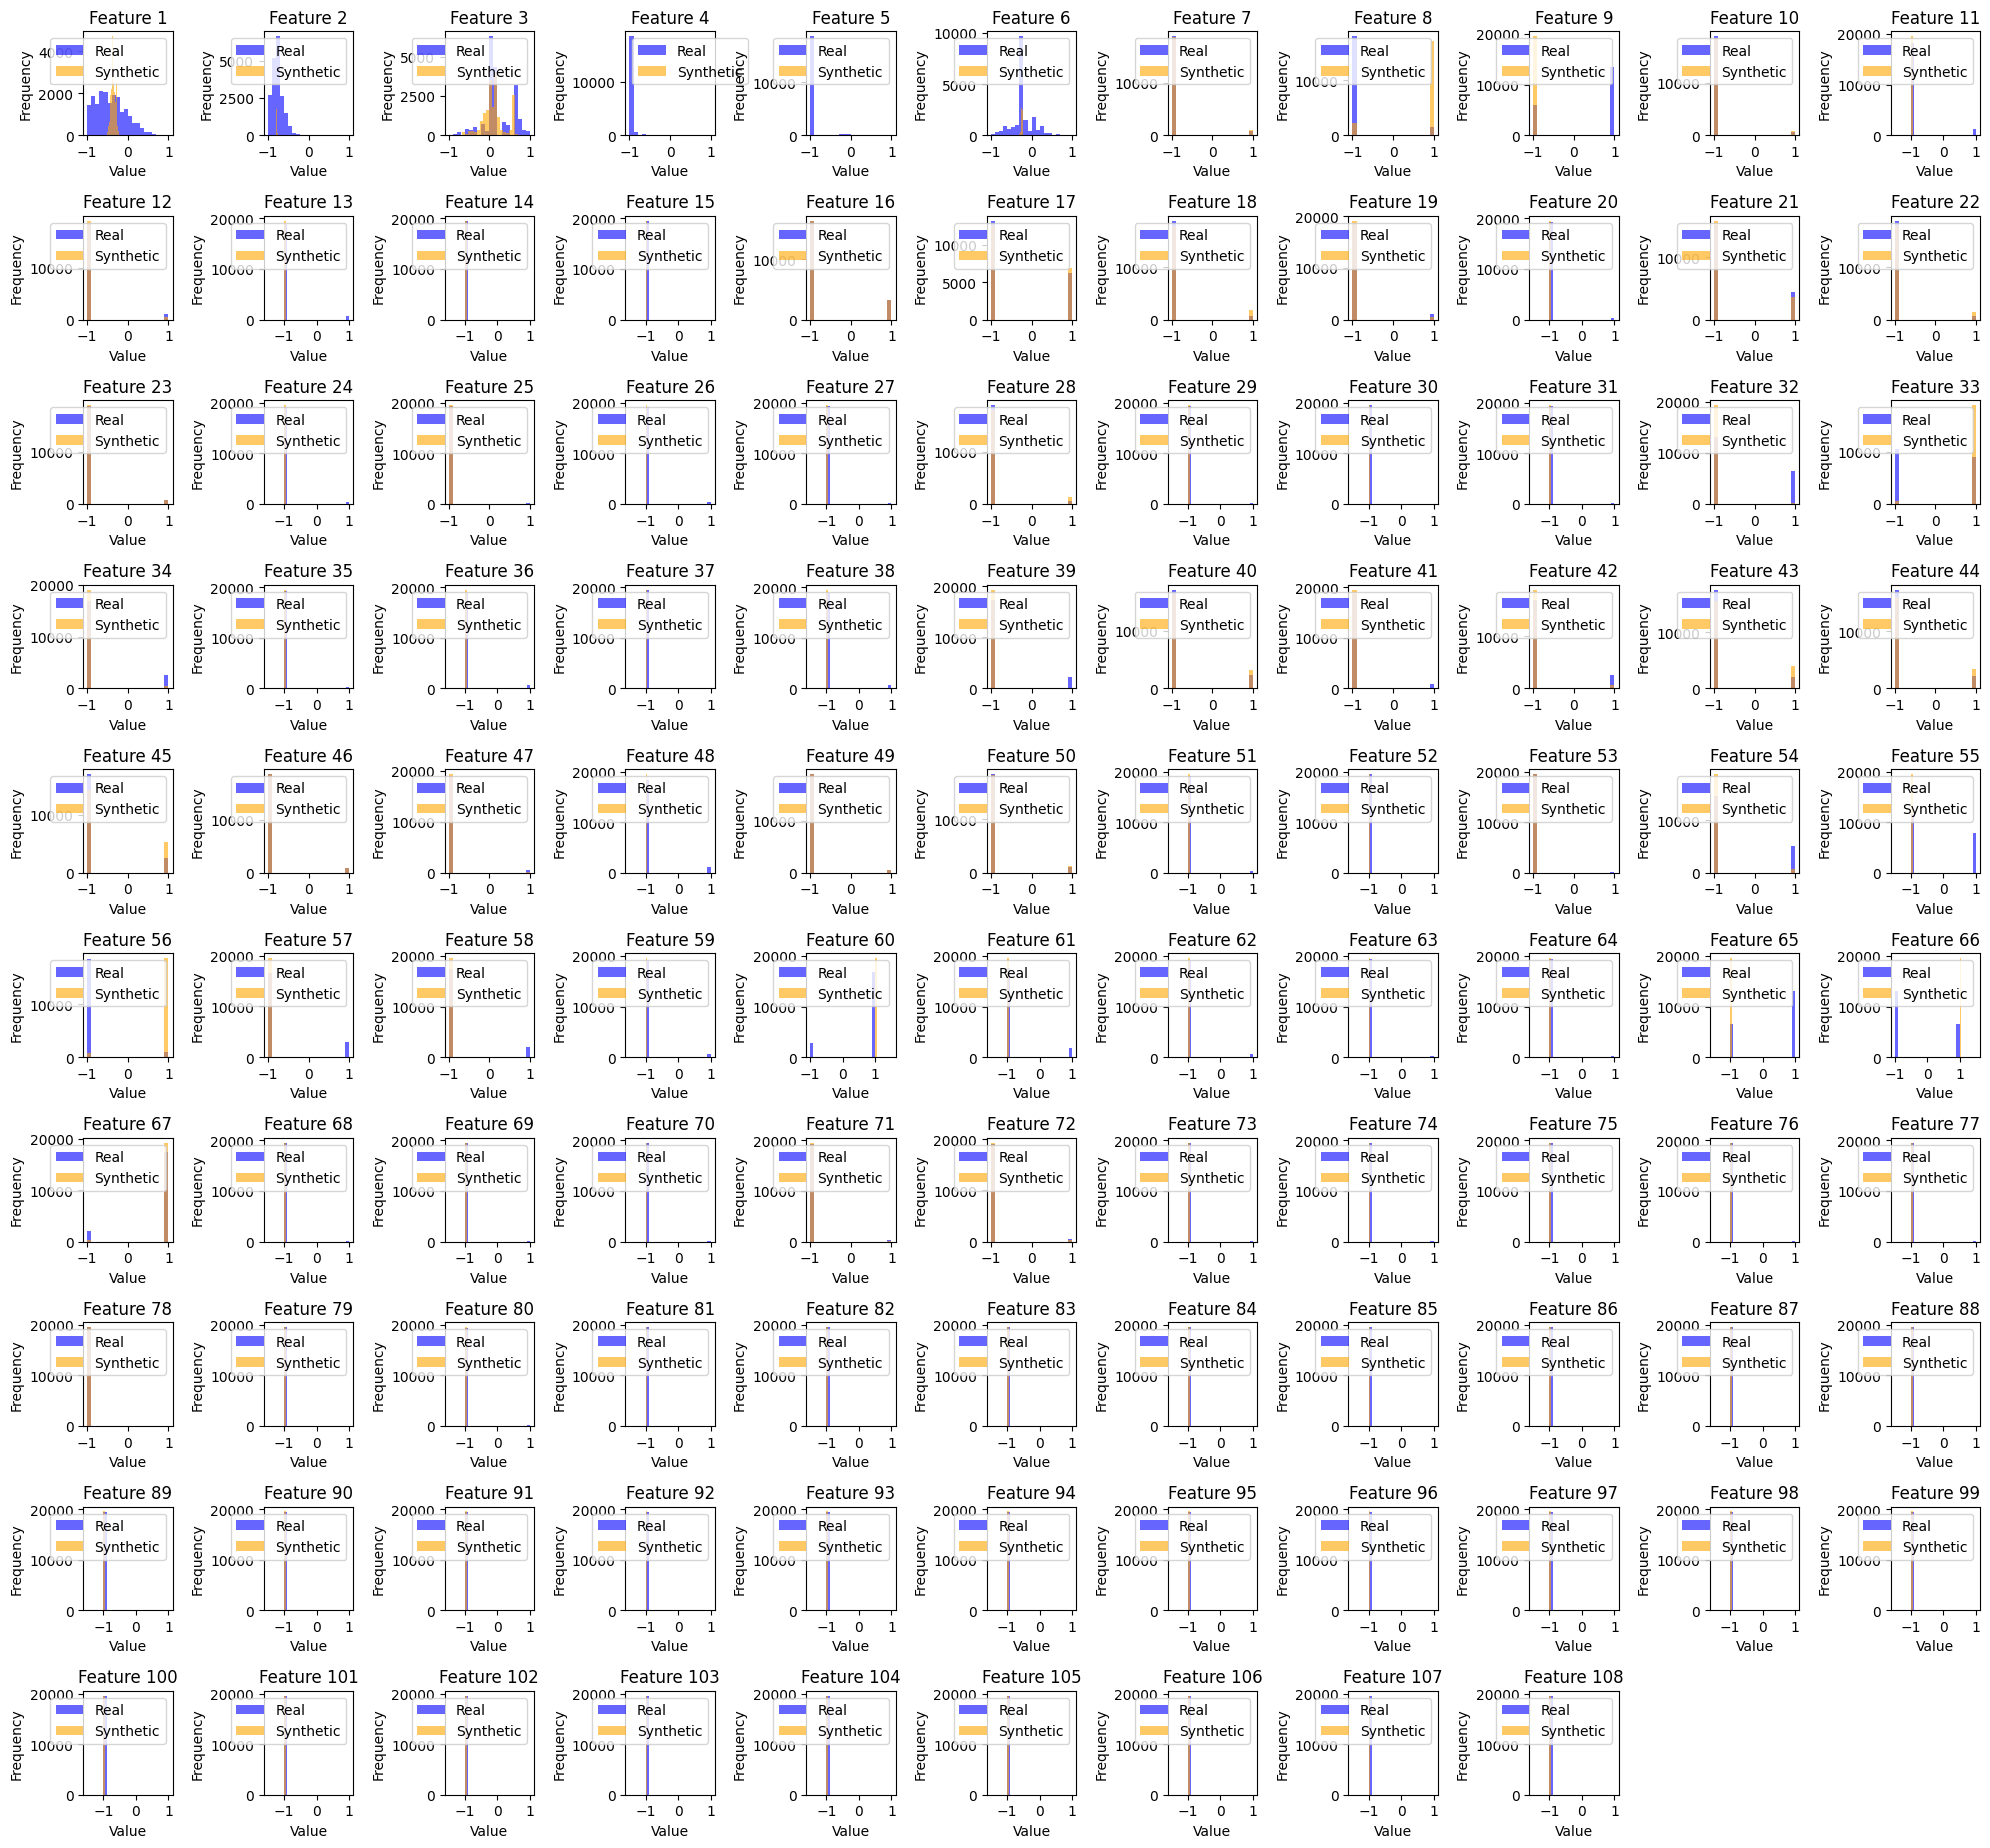

In [20]:
plot_histograms(real_data_features, synthetic_data, feature_names=None, bins=20)

In [21]:
def compute_corr_diff(real_data, synthetic_data):
    """
    Compute the absolute difference between the correlation matrices of real and synthetic data.

    Args:
        real_data (torch.Tensor or np.ndarray): Real data (features x samples).
        synthetic_data (torch.Tensor or np.ndarray): Generated data (features x samples).

    Returns:
        np.ndarray: Absolute difference between the correlation matrices.
    """
    # Convert to DataFrame if torch tensor
    if isinstance(real_data, torch.Tensor):
        real_data = real_data.cpu().numpy()
    if isinstance(synthetic_data, torch.Tensor):
        synthetic_data = synthetic_data.cpu().numpy()

    # Calculate correlation matrices
    real_corr = np.corrcoef(real_data.T)  # Transpose to get features x samples
    synthetic_corr = np.corrcoef(synthetic_data.T)
    
    # Replace NaN values in both correlation matrices with 1
    real_corr = np.nan_to_num(real_corr, nan=1)
    synthetic_corr = np.nan_to_num(synthetic_corr, nan=1)

    # Compute the absolute difference between correlation matrices
    corr_diff = np.abs(real_corr - synthetic_corr)

    return corr_diff

def plot_corr_diff(corr_diff):
    """
    Plot the absolute difference in correlation as a heatmap.

    Args:
        corr_diff (np.ndarray): The difference matrix.
    """
    # Create a heatmap for the correlation difference
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_diff, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title("Difference in Correlation Matrix (Real vs. Synthetic Data)")
    plt.show()

c:\Users\shaha\Projects\Python Projects\Deep Learning\ConditionalGAN\venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\shaha\Projects\Python Projects\Deep Learning\ConditionalGAN\venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


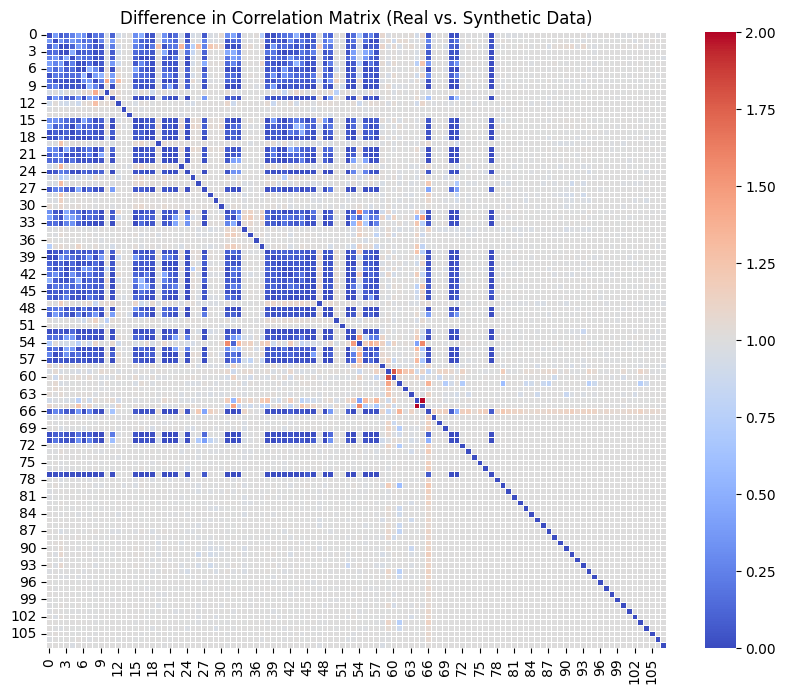

In [22]:
corr_diff = compute_corr_diff(real_data_features, synthetic_data)
plot_corr_diff(corr_diff)

# Testing Efficiency and Detection

In [11]:
# Detection Evaluation
def evaluate_detection(real_data, synthetic_data):
    # Create labels for real data (1 for real) and synthetic data (0 for fake)
    real_labels = np.ones(real_data.shape[0])  # All real data is marked as 1
    synthetic_labels = np.zeros(synthetic_data.shape[0])  # All synthetic data is marked as 0
    
    # Create a 50% real, 50% synthetic dataset
    combined_data = np.vstack([real_data, synthetic_data])
    combined_labels = np.concatenate([real_labels, synthetic_labels])

    # Stratified K-fold cross-validation
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=SEED)
    auc_scores = []

    for train_idx, test_idx in skf.split(combined_data, combined_labels):
        # Split data into training and testing
        X_train, X_test = combined_data[train_idx], combined_data[test_idx]
        y_train, y_test = combined_labels[train_idx], combined_labels[test_idx]

        # Train a Random Forest model
        rf_model = RandomForestClassifier(n_estimators=100, random_state=SEED)
        rf_model.fit(X_train, y_train)

        # Predict and calculate AUC
        y_pred = rf_model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)

    avg_auc = np.mean(auc_scores)
    print(f"Average AUC for detection: {avg_auc:.4f}")

# Efficacy Evaluation
def evaluate_efficacy(real_train_data, synthetic_train_data, test_data, test_labels):
    # Train a Random Forest on the real data
    rf_real = RandomForestClassifier(n_estimators=100, random_state=SEED)
    rf_real.fit(real_train_data, train_set.targets)  # Use train_set.targets for training labels
    real_auc = roc_auc_score(test_labels, rf_real.predict_proba(test_data)[:, 1])

    # Train a Random Forest on the synthetic data
    rf_synthetic = RandomForestClassifier(n_estimators=100, random_state=SEED)
    rf_synthetic.fit(synthetic_train_data, train_set.targets)  # Use train_set.targets for synthetic training labels
    synthetic_auc = roc_auc_score(test_labels, rf_synthetic.predict_proba(test_data)[:, 1])

    # Calculate efficacy
    efficacy_score = synthetic_auc / real_auc
    print(f"Real AUC: {real_auc} | Synthetic AUC: {synthetic_auc} | Efficacy Score: {efficacy_score:.4f}")

In [15]:
SEED = 42

dataset = TabularDataset(
    file_path=FULL_DATA_PATH,
    target_column=TARGET_COLUMN,
    augment=False,  # No augmentation for testing part
    info=False  # Print dataset info
)

# Perform stratified split
print("[Main]: Performing stratified train-val-test split...")
train_set, val_set, test_set = dataset.stratified_split(
    val_size=VAL_RATIO, test_size=TEST_RATIO, random_state=SEED
)
real_data_features = train_set.features
real_data_labels = train_set.targets

synthetic_data, synthetic_labels = generate_synthetic_data(cgan, LABEL_RATIO, len(real_data_features), NOISE_DIM, DEVICE)
# Now call the evaluation functions with the proper splits and synthetic data
evaluate_detection(real_data_features, synthetic_data)
evaluate_efficacy(train_set.features, synthetic_data, test_set.features, test_set.targets)

[Dataset Status]: Preprocessing dataset...
[Main]: Performing stratified train-val-test split...
Average AUC for detection: 1.0000
Real AUC: 0.905916742328883 | Synthetic AUC: 0.43209584769195847 | Efficacy Score: 0.4770


# Explaining the Differences

In [16]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

def explain_differences_with_tree(real_data, synthetic_data, max_depth=3):
    """
    Use a Decision Tree to explain differences between real and synthetic data.

    Args:
        real_data (np.ndarray): Array of real samples.
        synthetic_data (np.ndarray): Array of synthetic samples.
        max_depth (int): Maximum depth of the decision tree for interpretability.

    Returns:
        DecisionTreeClassifier: The trained decision tree model.
    """
    # Create labels: 1 for real, 0 for synthetic
    real_labels = np.ones(real_data.shape[0])
    synthetic_labels = np.zeros(synthetic_data.shape[0])

    # Combine data and labels
    combined_data = np.vstack([real_data, synthetic_data])
    combined_labels = np.concatenate([real_labels, synthetic_labels])

    # Train a decision tree classifier
    explanation_tree = DecisionTreeClassifier(max_depth=max_depth, random_state=SEED)
    explanation_tree.fit(combined_data, combined_labels)

    # Plot the decision tree
    print("Plotting the decision tree to explain differences...")
    plt.figure(figsize=(16, 10))
    plot_tree(
        explanation_tree,
        feature_names=[f"Feature {i}" for i in range(combined_data.shape[1])],
        class_names=["Synthetic", "Real"],
        filled=True,
        rounded=True,
    )
    plt.title("Decision Tree Explanation of Real vs. Synthetic Data")
    plt.show()

    # Feature importances
    feature_importances = explanation_tree.feature_importances_
    sorted_indices = np.argsort(feature_importances)[::-1]  # Sort in descending order

    print("Feature Importances (Top features that separate real and synthetic data):")
    for idx in sorted_indices:
        if feature_importances[idx] > 0:  # Only show features with non-zero importance
            print(f"Feature {idx}: {feature_importances[idx]:.4f}")

    return explanation_tree

Plotting the decision tree to explain differences...


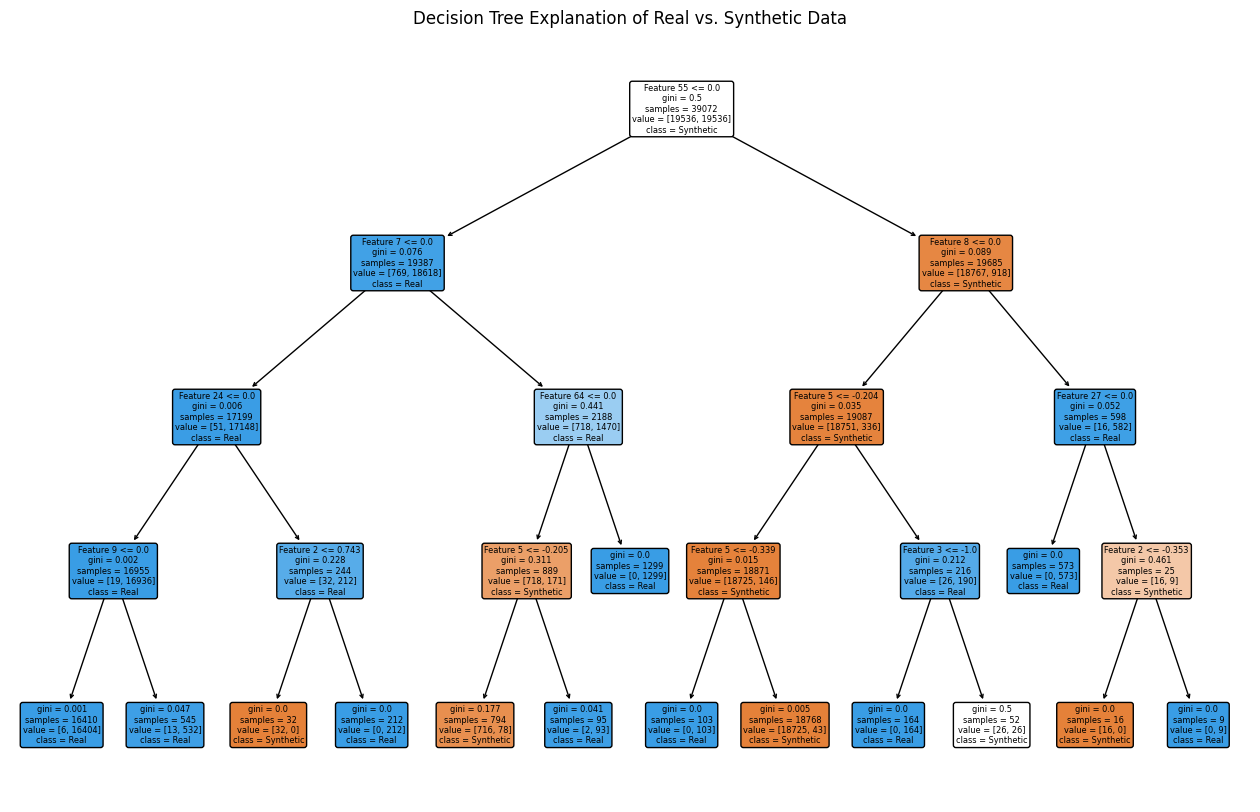

Feature Importances (Top features that separate real and synthetic data):
Feature 55: 0.8475
Feature 8: 0.0550
Feature 64: 0.0358
Feature 5: 0.0343
Feature 7: 0.0213
Feature 2: 0.0035
Feature 3: 0.0010
Feature 27: 0.0010
Feature 24: 0.0004
Feature 9: 0.0000


In [17]:
decision_tree_model = explain_differences_with_tree(real_data_features, synthetic_data, max_depth=4)